# Laboratorio 6 - Análisis de Redes sociales

### Sebastian Juarez - 21471
### Juan Pablo Cordón - 21458

Link al repositorio de Github: https://github.com/SebasJuarez/DS-Collection/tree/Lab6

## Avances

### Imports

In [10]:
import json, re, ast, sys, math, unicodedata
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.download("stopwords")
DATA_PATH = Path("./Data/tioberny.txt")

stopwords = nltk.corpus.stopwords.words("spanish")

URL_RE   = re.compile(r"https?://\S+|www\.\S+")
MENT_RE  = re.compile(r"@\w+")
HASH_RE  = re.compile(r"#\w+")
PUNC_RE  = re.compile(r"[^\w\sáéíóúüñ]")
MULTISPC = re.compile(r"\s+")
EMOJI_RANGES = [
    (0x1F300, 0x1FAD6), (0x1F600, 0x1F64F), (0x2700, 0x27BF),
    (0x1F900, 0x1F9FF), (0x1FA70, 0x1FAFF)
]
def strip_emojis(s: str) -> str:
    return "".join(ch for ch in s if not any(a<=ord(ch)<=b for a,b in EMOJI_RANGES))

def normalize_user(u):
    if pd.isna(u): return None
    u = str(u).strip()
    u = u[1:] if u.startswith("@") else u
    return u.lower()

def clean_text(s,
               to_lower=True,
               remove_urls=True,
               remove_hashtags=True,
               remove_mentions=True,
               remove_punct=True,
               remove_numbers=False,
               remove_emojis=True,
               remove_stopwords=True,
               keep_exclaim_question=True):
    if s is None: return ""
    t = str(s)
    if to_lower: t = t.lower()
    if remove_urls: t = URL_RE.sub(" ", t)
    if remove_hashtags: t = HASH_RE.sub(" ", t)
    if remove_mentions: t = MENT_RE.sub(" ", t)
    if remove_emojis: t = strip_emojis(t)
    # Mantenemos ! y ? para el analisis de sentimientos
    if remove_punct:
        if keep_exclaim_question:
            t = re.sub(r"[^\w\sáéíóúüñ!?]", " ", t)
        else:
            t = PUNC_RE.sub(" ", t)
    
    if remove_numbers: t = re.sub(r"\d+", " ", t)
    t = MULTISPC.sub(" ", t).strip()
    if remove_stopwords:
        t = " ".join(w for w in t.split() if w not in stopwords)
    return t



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jpcor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importar los datos de txt

In [11]:
from pathlib import Path
import json, ast, re
import pandas as pd

def sniff_encoding(path: Path) -> str:
    with path.open("rb") as fb:
        head = fb.read(4)
    if head.startswith(b"\xff\xfe") or head.startswith(b"\xfe\xff"):
        return "utf-16"
    if head.startswith(b"\xef\xbb\xbf"):
        return "utf-8-sig"
    return "utf-8"

def try_load(DATA_PATH: Path) -> pd.DataFrame:
    if not DATA_PATH.exists():
        raise FileNotFoundError(f"No existe: {DATA_PATH.resolve()}")

    enc = sniff_encoding(DATA_PATH)

    # JSONS
    try:
        records = []
        with DATA_PATH.open("r", encoding=enc, errors="strict", newline="") as f:
            first = f.read(1)
            rest  = f.read()
            content = (first or "") + rest
        content = content.strip()

        if content.startswith("[") and content.endswith("]"):
            records = json.loads(content)
        else:
            records = []
            for ln in content.splitlines():
                s = ln.strip()
                if not s or not s.startswith("{"):
                    continue
                try:
                    records.append(json.loads(s))
                except json.JSONDecodeError:
                    continue

        if records:
            df = pd.json_normalize(records)
        else:
            raise ValueError("No se detectó JSON válido.")
    except Exception:
        # CSVs
        try:
            df = pd.read_csv(DATA_PATH, encoding=enc, on_bad_lines="skip")
        except UnicodeDecodeError:
            df = pd.read_csv(DATA_PATH, encoding="latin-1", on_bad_lines="skip")
        except Exception:
            # TXTs como jsons
            records = []
            with DATA_PATH.open("r", encoding=enc, errors="ignore") as f:
                for ln in f:
                    s = ln.strip()
                    if not s: 
                        continue
                    try:
                        obj = ast.literal_eval(s)
                        records.append(obj)
                    except Exception:
                        pass
            if not records:
                raise
            df = pd.json_normalize(records)

    # Tomamos las columnas
    def pick(cols):
        for c in cols:
            if c in df.columns: return c
        return None

    id_col   = pick(["id","id_str","tweet.id","conversationId","conversationIdStr"])
    text_col = pick(["text","rawContent","full_text","tweet.text"])
    dt_col   = pick(["created_at","date","tweet.created_at"])
    user_col = pick(["user.screen_name","user.username","user.name","username","user"])
    uid_col  = pick(["user.id","user.id_str","userId","user.id_str"])
    reply_to = pick(["in_reply_to_screen_name","inReplyToUser","in_reply_to_user","inReplyToUsername"])
    rt_of    = pick(["retweeted_status.user.screen_name","retweeted_user","retweet_of"])
    like_c   = pick(["favorite_count","likeCount","tweet.favorite_count"])
    rt_c     = pick(["retweet_count","retweetCount","tweet.retweet_count"])
    ment_col = pick(["entities.user_mentions","mentionedUsers","mentions"])

    out = pd.DataFrame({
        "id": df.get(id_col),
        "created_at": df.get(dt_col),
        "user_id": df.get(uid_col),
        "username": df.get(user_col),
        "text": df.get(text_col),
        "in_reply_to": df.get(reply_to),
        "retweet_of": df.get(rt_of),
        "like_count": df.get(like_c),
        "rt_count": df.get(rt_c),
        "mentions_raw": df.get(ment_col),
        "raw": df.to_dict(orient="records")
    })

    def normalize_user(u):
        if pd.isna(u): return None
        u = str(u).strip()
        u = u[1:] if u.startswith("@") else u
        return u.lower()

    def to_mention_list(x):
        if isinstance(x, list):
            m = []
            for it in x:
                if isinstance(it, dict):
                    val = it.get("username") or it.get("screen_name")
                    if val: m.append(normalize_user(val))
                else:
                    m.append(normalize_user(it))
            return m
        import re
        MENT_RE = re.compile(r"@\w+")
        return [normalize_user(m) for m in MENT_RE.findall(str(x))] if pd.notna(x) else []

    out["username"]    = out["username"].map(normalize_user)
    out["in_reply_to"] = out["in_reply_to"].map(normalize_user)
    out["retweet_of"]  = out["retweet_of"].map(normalize_user)
    out["mentions"]    = out["mentions_raw"].apply(to_mention_list)

    return out

# Pequeña visualización
tweets = try_load(DATA_PATH)
print("Shape:", tweets.shape)
tweets.head(3)


Shape: (5019, 12)


,id,created_at,user_id,username,text,in_reply_to,retweet_of,like_count,rt_count,mentions_raw,raw,mentions
0,1834281080029110288,2024-09-12 17:21:03+00:00,1435062946598694914,la_revoluzzion,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",None,None,0,0,"[{'id': 23664866, 'id_str': '23664866', 'usern...","{'id': 1834281080029110288, 'id_str': '1834281...","[usembassyguate, 48cantonestoto, usaidguate, u..."
1,1834252464092069901,2024-09-12 15:27:20+00:00,956650778634145792,xelanewsgt,#URGENTE Lo que los medios #faferos no informa...,None,None,142,80,[],"{'id': 1834252464092069901, 'id_str': '1834252...",[]
2,1834280919336976681,2024-09-12 17:20:25+00:00,1087057038755143680,m24095273,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,None,None,0,0,"[{'id': 77653794, 'id_str': '77653794', 'usern...","{'id': 1834280919336976681, 'id_str': '1834280...","[ivanduque, barevalodeleon]"


### Limpieza ajustable de simbolos y stopwords

In [12]:
CFG = dict(
    to_lower=True,
    remove_urls=True,
    remove_hashtags=True,
    remove_mentions=True,
    remove_punct=True,
    remove_numbers=False,
    remove_emojis=True,
    remove_stopwords=True
)

tweets["text_clean"] = tweets["text"].apply(lambda s: clean_text(s, **CFG))
tweets["len_chars"]  = tweets["text_clean"].str.len()
tweets["n_words"]    = tweets["text_clean"].str.split().str.len()
tweets.sample(5)[["username","text","text_clean","n_words"]]


,username,text,text_clean,n_words
665,rjgdavi,@BArevalodeLeon Estimado Señor Presidente buen...,estimado señor presidente buenas noches atrevo...,21
4438,marlonzank89095,@Cris0b @AbueloDeSiete @BArevalodeLeon Hijo de...,hijo quién es?,3
4944,carlosg55665451,@IsaPaiz_ @BArevalodeLeon @KarinHerreraVP En q...,planeta,1
1287,oco_motora,@Chrizzao @__VaderTG @BArevalodeLeon @USAIDGua...,,0
4223,alvar4jose,@BArevalodeLeon Este es un ejemplo de gobierno...,ejemplo gobierno pueblo,3


### Duplicados

In [13]:
tweets = tweets.drop_duplicates(subset=["id"]).copy()
tweets = tweets.drop_duplicates(subset=["text_clean"]).copy()

tweets["username"] = tweets["username"].map(normalize_user)
tweets["mentions"] = tweets["mentions"].apply(lambda L: [normalize_user(u) for u in (L or []) if u])


In [14]:
EDGE_ROWS = []

for _, r in tweets.iterrows():
    author = r["username"]
    if not author: 
        continue

    # MENCIONES: author --> mentioned
    for m in (r["mentions"] or []):
        if m and m != author:
            EDGE_ROWS.append({"src": author, "dst": m, "type": "mention", "tweet_id": r["id"]})

    # RESPUESTAS: author --> in_reply_to
    if pd.notna(r.get("in_reply_to")) and r["in_reply_to"] and r["in_reply_to"] != author:
        EDGE_ROWS.append({"src": author, "dst": r["in_reply_to"], "type": "reply", "tweet_id": r["id"]})

    # RETWEETS: author --> usuario original
    if pd.notna(r.get("retweet_of")) and r["retweet_of"] and r["retweet_of"] != author:
        EDGE_ROWS.append({"src": author, "dst": r["retweet_of"], "type": "retweet", "tweet_id": r["id"]})

edges = pd.DataFrame(EDGE_ROWS)
print(edges.type.value_counts(dropna=False))
edges.head(10)


mention    15511
Name: type, dtype: int64


,src,dst,type,tweet_id
0,la_revoluzzion,usembassyguate,mention,1834281080029110288
1,la_revoluzzion,48cantonestoto,mention,1834281080029110288
2,la_revoluzzion,usaidguate,mention,1834281080029110288
3,la_revoluzzion,ueguatemala,mention,1834281080029110288
4,la_revoluzzion,barevalodeleon,mention,1834281080029110288
5,m24095273,ivanduque,mention,1834280919336976681
6,m24095273,barevalodeleon,mention,1834280919336976681
7,carlosalbesc,ivanduque,mention,1834280512933732694
8,carlosalbesc,barevalodeleon,mention,1834280512933732694
9,brenda_agn,barevalodeleon,mention,1834279986254987428


In [15]:
print("edges shape:", edges.shape)
print("types:", edges["type"].value_counts(dropna=False))

print("\nMuestra de edges:")
display(edges.sample(min(10, len(edges)))[["src","dst","type"]])

print("\nNulos en src/dst/type:",
      edges["src"].isna().sum(),
      edges["dst"].isna().sum(),
      edges["type"].isna().sum())


edges shape: (15511, 4)
types: mention    15511
Name: type, dtype: int64

Muestra de edges:


,src,dst,type
4559,gersongudielcas,guatemalagob,mention
7347,arthur1949asd,santipalomov,mention
9271,gilrey422483,e_morales2250,mention
4786,kikegt2023,olsenpsico,mention
7306,bmincho09,olsenpsico,mention
6550,bernardosilvagt,barevalodeleon,mention
5049,brucew1235,geooroz,mention
12573,nosoynetcenter,barevalodeleon,mention
743,la_revoluzzion,barevalodeleon,mention
1733,dennisskate1,ciudadanocomung,mention



Nulos en src/dst/type: 0 0 0


### Construcción de la Adyacencia

In [16]:
adj_total_df = edges.pivot_table(index="src", columns="dst", values="tweet_id",
                                 aggfunc="count", fill_value=0)

users = sorted(set(adj_total_df.index).union(set(adj_total_df.columns)))
adj_total_df = adj_total_df.reindex(index=users, columns=users, fill_value=0)

adj_by_type = {k: g.pivot_table(index="src", columns="dst", values="tweet_id",
                                aggfunc="count", fill_value=0)
               for k, g in edges.groupby("type")}
for k, A in adj_by_type.items():
    adj_by_type[k] = A.reindex(index=users, columns=users, fill_value=0)

A_mention = adj_by_type.get("mention", pd.DataFrame(0, index=users, columns=users)).values
A_reply   = adj_by_type.get("reply",   pd.DataFrame(0, index=users, columns=users)).values
A_retweet = adj_by_type.get("retweet", pd.DataFrame(0, index=users, columns=users)).values


In [17]:
print("Pesos totales:", adj_total_df.values.sum())
print("Top 10 de las cuentas que mas interactuan con las demas:")
display(adj_total_df.sum(axis=1).sort_values(ascending=False).head(10))
print("Top 10 cuentas que mas reciben interacciones:")
display(adj_total_df.sum(axis=0).sort_values(ascending=False).head(10))


Pesos totales: 15511
Top 10 de las cuentas que mas interactuan con las demas:


src
elrevoltijogt      197
alejand09098718    118
ialmgg              92
leraovalle          81
mendiamariela       76
diariodeca          74
billyc2023          73
gilrey422483        73
edwadriperez        66
claudiayan8074      61
dtype: int64

Top 10 cuentas que mas reciben interacciones:


dst
barevalodeleon    4362
guatemalagob       813
ubaldomacu         532
santipalomov       482
mpguatemala        429
fjimenezmingob     366
mingobguate        252
__vadertg          251
congresoguate      234
usaidguate         197
dtype: int64

### Grafo interactivo en HTML (Datos completos)

In [18]:
import networkx as nx
try:
    from pyvis.network import Network
except ImportError:
    # !pip install pyvis
    from pyvis.network import Network

ego = "barevalodeleon"

ego_edges = edges[(edges["src"] == ego) | (edges["dst"] == ego)]

G = nx.DiGraph()
for _, e in ego_edges.iterrows():
    src, dst, t = e["src"], e["dst"], e["type"]
    if not src or not dst: 
        continue
    if G.has_edge(src, dst):
        G[src][dst]["weight"] += 1
        G[src][dst]["types"].add(t)
    else:
        G.add_edge(src, dst, weight=1, types={t})

net = Network(height="600px", width="100%", directed=True, notebook=True, bgcolor="#222222", font_color="white")

for node in G.nodes():
    size = 20 if node == ego else 10
    color = "red" if node == ego else "lightblue"
    net.add_node(node, label=node, size=size, color=color)

for u, v, data in G.edges(data=True):
    label = ",".join(list(data["types"]))
    net.add_edge(u, v, value=data["weight"], title=f"{label} ({data['weight']})")

net.show("ego_barevalodeleon.html")


ModuleNotFoundError: No module named 'pyvis'

### Grafo estático (menos info)

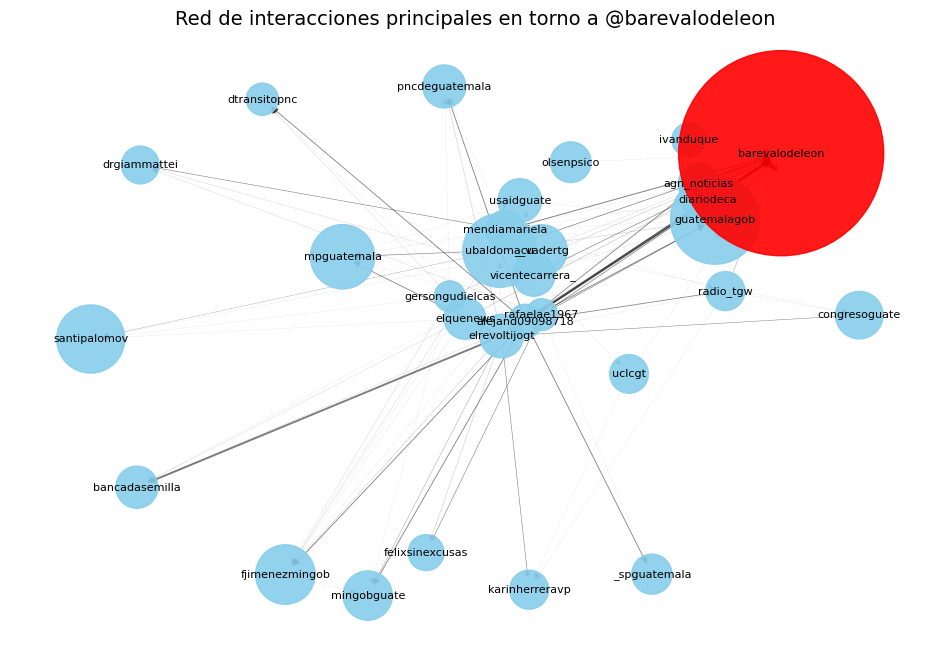

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Usamos los edges filtrados
G = nx.DiGraph()
for _, e in edges.iterrows():
    src, dst, t = e["src"], e["dst"], e["type"]
    if not src or not dst:
        continue
    if G.has_edge(src, dst):
        G[src][dst]["weight"] += 1
        G[src][dst]["types"].add(t)
    else:
        G.add_edge(src, dst, weight=1, types={t})

deg_total = dict(G.degree(weight="weight"))

# top 30 de usuarios que mas interaccionan con Arevalo
top_users = sorted(deg_total, key=deg_total.get, reverse=True)[:30]
H = G.subgraph(top_users).copy()

pos = nx.spring_layout(H, k=0.5, iterations=50, seed=42)

node_sizes = [deg_total[n]*5 for n in H.nodes()]

# Resaltamos a Arevalo
node_colors = ["red" if n=="barevalodeleon" else "skyblue" for n in H.nodes()]

# Grafo
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(H, pos, width=[d["weight"]*0.05 for (_,_,d) in H.edges(data=True)], alpha=0.5, arrows=True)
nx.draw_networkx_labels(H, pos, font_size=8, font_color="black")

plt.title("Red de interacciones principales en torno a @barevalodeleon", fontsize=14)
plt.axis("off")
plt.show()


## Análisis Exploratorio

Número total de tweets: 4495
Número de usuarios únicos: 2471
Número total de menciones: 15511
Top 10 hashtags frecuentes:
guatemalasaleadelante           19
urgente                         17
guatemala                       16
minfinsaleadelante              12
enelpaísdca                     12
presupuesto2025                 11
unpresupuestoparalapoblación    10
nacionalesagn                    8
traficogt                        6
ahora                            6
dtype: int64


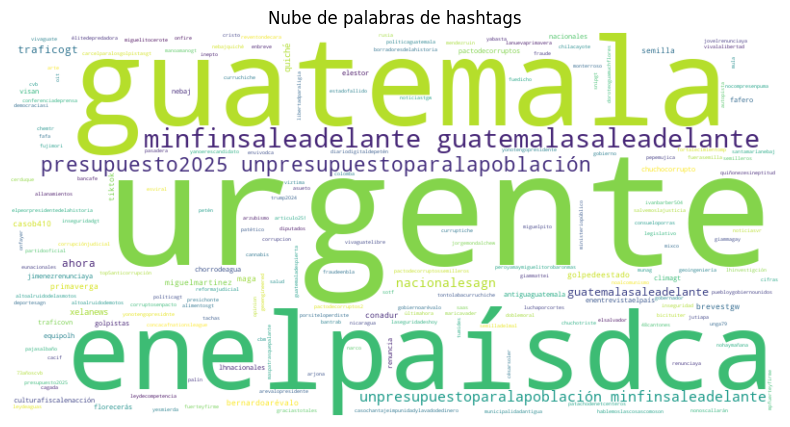

In [28]:
# Análisis exploratorio básico
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Número de tweets
num_tweets = len(tweets)
print(f"Número total de tweets: {num_tweets}")

# Número de usuarios únicos
num_users = tweets['username'].nunique()
print(f"Número de usuarios únicos: {num_users}")

# Número total de menciones
num_mentions = sum(len(m) for m in tweets['mentions'])
print(f"Número total de menciones: {num_mentions}")

# Hashtags frecuentes
def extract_hashtags(text):
    return [tag.lower() for tag in re.findall(r"#(\w+)", str(text))]
tweets['hashtags'] = tweets['text'].apply(extract_hashtags)
all_hashtags = [tag for tags in tweets['hashtags'] for tag in tags]
hashtag_freq = pd.Series(all_hashtags).value_counts()
print("Top 10 hashtags frecuentes:")
print(hashtag_freq.head(10))

# Nube de palabras de hashtags
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_hashtags))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de hashtags')
plt.show()

**¿Cuáles son los usuarios más mencionados en la red, aparte de Bernardo Arévalo**

In [ ]:
# Usuarios más mencionados, excepto Bernardo Arévalo
mention_counts = pd.Series([m for mentions in tweets['mentions'] for m in mentions]).value_counts()
mention_counts = mention_counts[mention_counts.index != 'barevalodeleon']
print("Top 10 usuarios más mencionados:")
print(mention_counts.head(10))

Top 5 usuarios más mencionados:
guatemalagob      813
ubaldomacu        532
santipalomov      482
mpguatemala       429
fjimenezmingob    366
mingobguate       252
__vadertg         251
congresoguate     234
usaidguate        197
diariodeca        195
dtype: int64


La mayoría de cuentas mencionadas son institucionales o de personajes relevantes del gobierno.
- 5 cuentas de instituciones del país: Las cuentas oficiales del Gobierno, el Ministerio Público, el Ministerio de Gobernación, el Congreso, y el Diario de Centroamerica
- 2 personalidades del gobierno: El Secretario de comunicación Santiago Palomo y el Ministro de Gobernación Francisco Jiménez
- 1 institución extranjera: USAID
- y 2 cuentas no institucionales, una es _vadertg, un conocido netcenter

**¿En qué fechas fueron recolectados los tweets?**

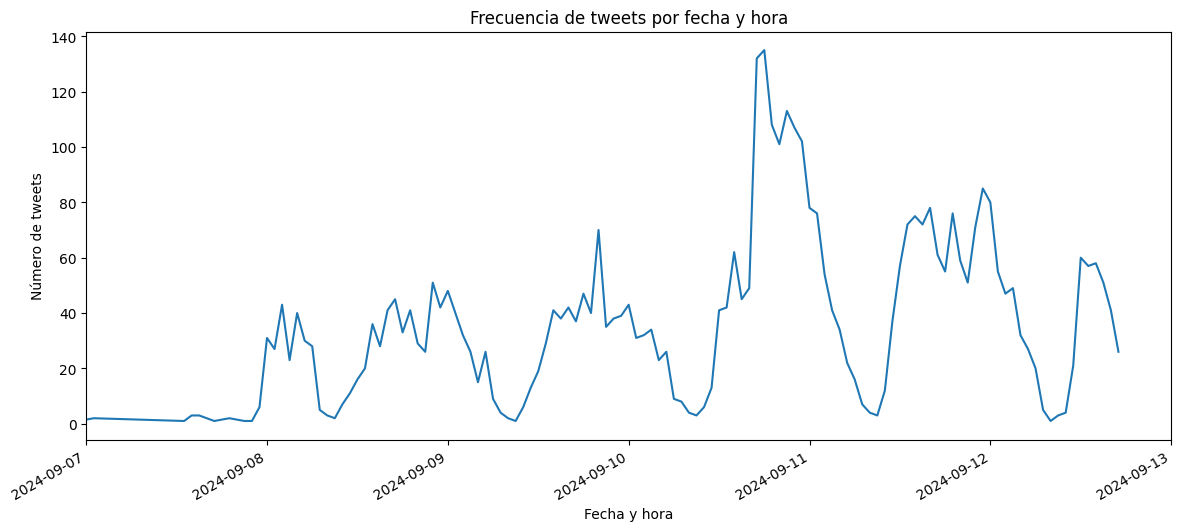

In [43]:
plt.figure(figsize=(14,6))
tweets['created_at'] = pd.to_datetime(tweets['created_at'], errors='coerce')
tweets['created_at'].dt.floor('H').value_counts().sort_index().plot()
plt.title('Frecuencia de tweets por fecha y hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de tweets')
# Colocar solo los tweets de septiembre de 2024
plt.xlim(pd.Timestamp('2024-09-07'), pd.Timestamp('2024-09-13'))
plt.show()

**¿Qué palabras son los que predominan en los tweets?**

Top 20 palabras más frecuentes:
si: 464
presidente: 384
gobierno: 317
solo: 286
guatemala: 209
vos: 192
ser: 180
corruptos: 173
usted: 166
bien: 165
mierda: 159
q: 157
hacer: 155
ahora: 154
mejor: 152
así: 150
país: 142
pueblo: 139
señor: 136
gente: 129


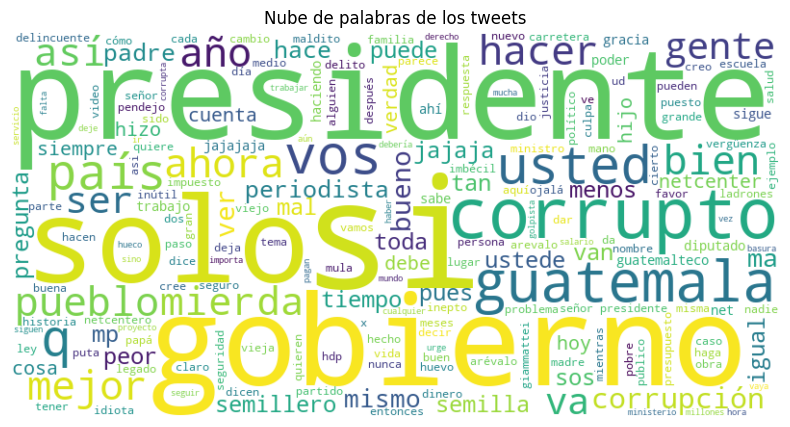

In [44]:
# Palabras más frecuentes en los tweets (excluyendo stopwords y símbolos)
from collections import Counter
all_words = ' '.join(tweets['text_clean']).split()
word_freq = Counter(all_words)
print('Top 20 palabras más frecuentes:')
for word, freq in word_freq.most_common(20):
    print(f'{word}: {freq}')

# Nube de palabras de los tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de los tweets')
plt.show()


## Análisis de red

In [27]:
from collections import Counter


# Nodos más conectados (mayor grado)
degree_dict = dict(G.degree())
top_nodes = Counter(degree_dict)
print("="*50,'\n Top nodos más conectados:')
i = 1
for node, degree in top_nodes.most_common(10):
    print(f'{i}. {node}: {degree} conexiones')
    i+=1

# Métricas de red clave
# Densidad de la red
density = nx.density(G)
print("="*50,f'\n Densidad de la red: {density:.4f}')

# Diámetro de la red (solo si la red es fuertemente conexa)
if nx.is_strongly_connected(G):
    diameter = nx.diameter(G)
    print(f'Diámetro de la red: {diameter}')
else:
    print("="*50,f'\n La red no es fuertemente conexa, el diámetro no está definido.')

# Coeficiente de agrupamiento (clustering)
clustering = nx.average_clustering(G.to_undirected())
print("="*50,f'\n Coeficiente de agrupamiento promedio: {clustering:.4f}')

 Top nodos más conectados:
1. barevalodeleon: 2374 conexiones
2. guatemalagob: 573 conexiones
3. ubaldomacu: 396 conexiones
4. santipalomov: 346 conexiones
5. mpguatemala: 315 conexiones
6. fjimenezmingob: 265 conexiones
7. __vadertg: 222 conexiones
8. congresoguate: 205 conexiones
9. mingobguate: 182 conexiones
10. usaidguate: 181 conexiones
 Densidad de la red: 0.0013
 La red no es fuertemente conexa, el diámetro no está definido.
 Coeficiente de agrupamiento promedio: 0.3706


## Identificación y análisis de comunidades

Tamaño de las 3 comunidades más grandes:
Comunidad 5: 1013 nodos
Comunidad 10: 314 nodos
Comunidad 0: 289 nodos


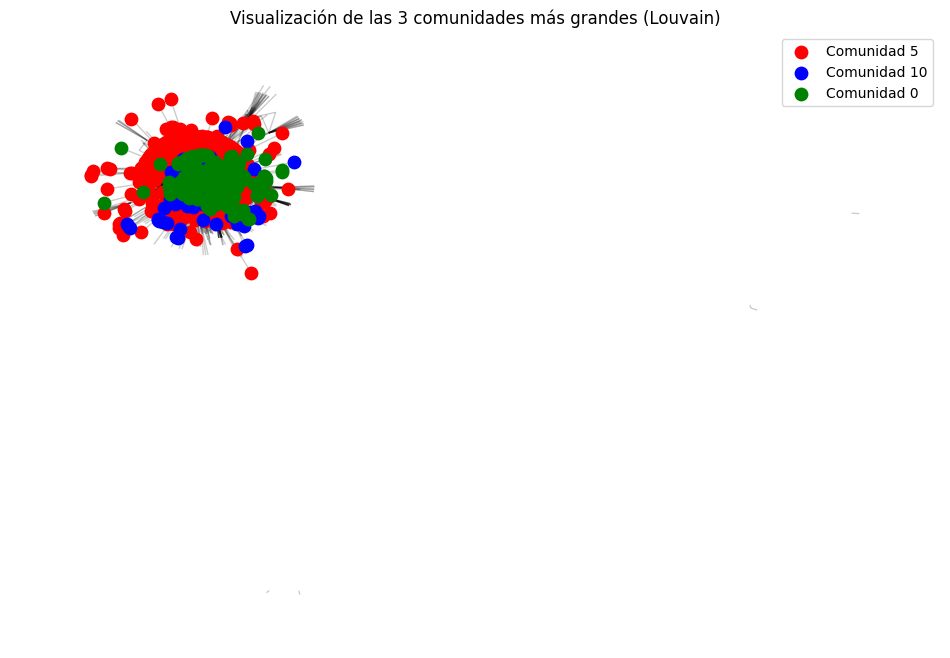


Temas principales en Comunidad 5:
presidente, si, gobierno, solo, guatemala, usted, q, bien, hacer, vos, mierda, ser, señor, padre, corruptos

Temas principales en Comunidad 10:
si, gobierno, vos, solo, presidente, periodista, ahora, pregunta, usted, mierda, jajaja, mejor, net, ser, netcenter

Temas principales en Comunidad 0:
presidente, si, ministro, gobierno, solo, bien, guatemala, país, señor, q, alimentos, familias, trabajando, trabajo, corrupción


In [61]:
# Detección de comunidades con el algoritmo de Louvain
import networkx as nx
try:
    import community as community_louvain
except ImportError:
    # !pip install python-louvain
    import community as community_louvain

# Grafo sin pesos para Louvain
G_undirected = G.to_undirected()

# Colocar seed para reproducibilidad
np.random.seed(50)
partition = community_louvain.best_partition(G_undirected)


# Agregar comunidad a cada nodo
nx.set_node_attributes(G_undirected, partition, 'community')

# Caracterización de comunidades
from collections import Counter
community_sizes = Counter(partition.values())
top_communities = [c for c, _ in community_sizes.most_common(3)]
print('Tamaño de las 3 comunidades más grandes:')
for c in top_communities:
    print(f'Comunidad {c}: {community_sizes[c]} nodos')

# Visualización de las 3 comunidades más grandes
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G_undirected, seed=42)
colors = ['red', 'blue', 'green', 'gray', 'orange', 'purple']
for i, com in enumerate(top_communities):
    nodes = [n for n in G_undirected.nodes() if partition[n] == com]
    nx.draw_networkx_nodes(G_undirected, pos, nodelist=nodes, node_size=80, node_color=colors[i%len(colors)], label=f'Comunidad {com}')
nx.draw_networkx_edges(G_undirected, pos, alpha=0.2)
plt.legend()
plt.title('Visualización de las 3 comunidades más grandes (Louvain)')
plt.axis('off')
plt.show()

# Temas principales de cada comunidad
for c in top_communities:
    nodes = [n for n in G_undirected.nodes() if partition[n] == c]
    tweets_com = tweets[tweets['username'].isin(nodes)]
    all_words = ' '.join(tweets_com['text_clean']).split()
    word_freq = Counter(all_words)
    print(f'\nTemas principales en Comunidad {c}:')
    print(', '.join([w for w, _ in word_freq.most_common(15)]))


Top 20 palabras más frecuentes:
si            464
presidente    384
gobierno      317
solo          286
guatemala     209
vos           192
ser           180
corruptos     173
usted         166
bien          165
mierda        159
q             157
hacer         155
ahora         154
mejor         152
así           150
país          142
pueblo        139
señor         136
gente         129
dtype: int64

Top 15 palabras en Comunidad 5 (excluyendo top 20 globales):
padre, hijo, va, años, debe, hace, ver, puede, arévalo, ustedes, corrupto, sos, bueno, peor, arevalo

Top 15 palabras en Comunidad 10 (excluyendo top 20 globales):
periodista, pregunta, jajaja, net, netcenter, periodistas, ?, puede, sos, !, mal, tan, años, preguntas, ustedes

Top 15 palabras en Comunidad 0 (excluyendo top 20 globales):
ministro, alimentos, familias, trabajando, trabajo, corrupción, hace, debe, ver, gracias, van, va, santa, maría, nebaj

Nube de palabras para Comunidad 5:


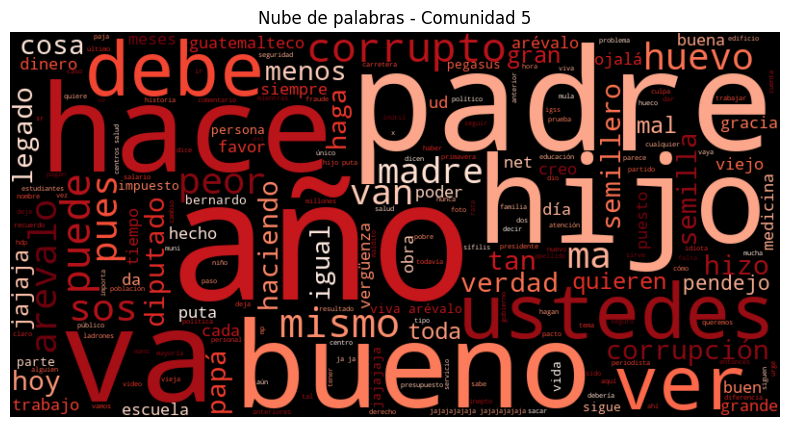


Nube de palabras para Comunidad 10:


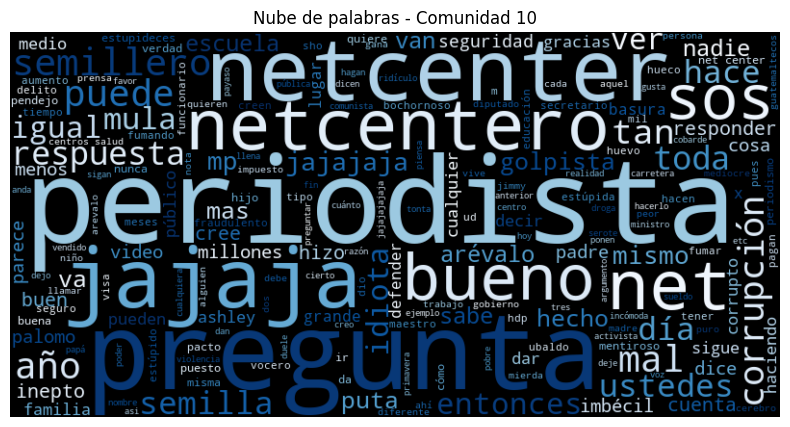


Nube de palabras para Comunidad 0:


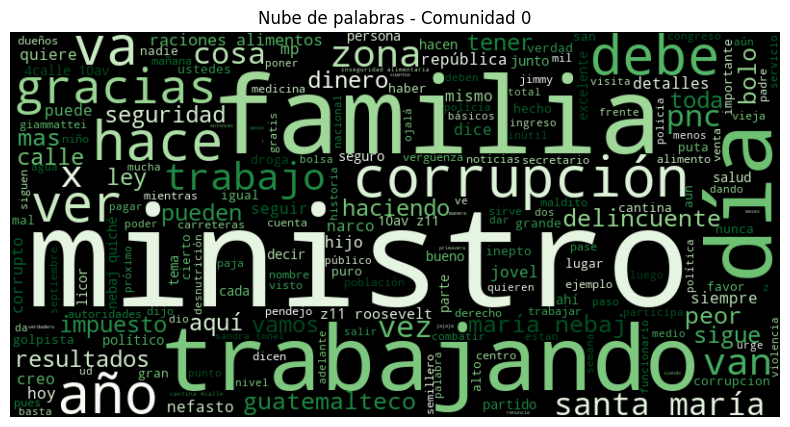

In [66]:
# Hacer nube de palabras para las 3 comunidades, excluyendo las 20 palabras más frecuentes

# Palabras clave en todos los tweets
all_words = ' '.join(tweets['text_clean']).split()
word_freq = Counter(all_words)
print('\nTop 20 palabras más frecuentes:')
print(pd.Series(dict(word_freq.most_common(20))))
top_20_words = set(w for w, _ in word_freq.most_common(20))


# Palabras clave por comunidad (excluyendo las top 20 globales)
for c in top_communities:
    nodes = [n for n in G_undirected.nodes() if partition[n] == c]
    tweets_com = tweets[tweets['username'].isin(nodes)]
    all_words = [w for w in ' '.join(tweets_com['text_clean']).split() if w not in top_20_words]
    word_freq = Counter(all_words)
    print(f'\nTop 15 palabras en Comunidad {c} (excluyendo top 20 globales):')
    print(', '.join([w for w, _ in word_freq.most_common(15)]))

# Paleta de colores para cada comunidad: rojo, azul, verde
colors = ['Reds', 'Blues', 'Greens']

for c, color in zip(top_communities, colors):
    nodes = [n for n in G_undirected.nodes() if partition[n] == c]
    tweets_com = tweets[tweets['username'].isin(nodes)]
    all_words = [w for w in ' '.join(tweets_com['text_clean']).split() if w not in top_20_words]
    word_freq = Counter(all_words)
    
    print(f'\nNube de palabras para Comunidad {c}:')
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap=color).generate(' '.join(all_words))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras - Comunidad {c}')
    plt.show()

In [67]:
# Tweets y cuentas más representativas de cada comunidad
for c in top_communities:
    print(f'\n--- Comunidad {c} ---')
    nodes = [n for n in G_undirected.nodes() if partition[n] == c]
    tweets_com = tweets[tweets['username'].isin(nodes)]

    # Cuentas más grandes de la comunidad (por número de interacciones)
    deg_com = {n: deg_total[n] for n in nodes}
    top_accounts = Counter(deg_com).most_common(10)
    print('Cuentas más grandes (por número de interacciones):')
    print(pd.Series(dict(top_accounts)))



--- Comunidad 5 ---
Cuentas más grandes (por número de interacciones):
barevalodeleon     4362
olsenpsico          172
ivanduque           119
gersongudielcas      99
benitoc67601310      78
drewzecena           68
factor4_gt           65
salquevedo           62
guate_opina          48
spaceboy88fly        46
dtype: int64

--- Comunidad 10 ---
Cuentas más grandes (por número de interacciones):
ubaldomacu         564
santipalomov       482
mpguatemala        430
ialmgg              95
wichomarg           73
pollosdb            58
jer21668            41
patrici07680625     37
dimb502             31
mariamartaumaa1     29
dtype: int64

--- Comunidad 0 ---
Cuentas más grandes (por número de interacciones):
guatemalagob       821
fjimenezmingob     368
diariodeca         269
mingobguate        252
pncdeguatemala     192
agn_noticias       177
_spguatemala       167
radio_tgw          158
alejand09098718    119
dtransitopnc       108
dtype: int64


## Análisis de influencers y nodos clave

In [69]:
# 7. Análisis de influencers y nodos clave
import networkx as nx
import pandas as pd

print('--- Centralidad de grado (más conexiones directas) ---')
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print(pd.Series(dict(top_degree)))

print('\n--- Centralidad de intermediación (puentes entre comunidades) ---')
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print(pd.Series(dict(top_betweenness)))

print('\n--- Centralidad de cercanía (menor cantidad de saltos) ---')
try:
    closeness_centrality = nx.closeness_centrality(G)
    top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print(pd.Series(dict(top_closeness)))
except Exception as e:
    print('No se pudo calcular la centralidad de cercanía:', e)

# Puedes visualizar los resultados o filtrar por comunidad si lo deseas

--- Centralidad de grado (más conexiones directas) ---
barevalodeleon    0.813014
guatemalagob      0.196233
ubaldomacu        0.135616
santipalomov      0.118493
mpguatemala       0.107877
fjimenezmingob    0.090753
__vadertg         0.076027
congresoguate     0.070205
mingobguate       0.062329
usaidguate        0.061986
dtype: float64

--- Centralidad de intermediación (puentes entre comunidades) ---
ubaldomacu         0.010636
benitoc67601310    0.009022
rafaelae1967       0.005596
axelgar56163124    0.002296
anti_chairosgt     0.001772
rafaeldelaguil8    0.001624
wichomarg          0.001407
__vadertg          0.001293
mendiamariela      0.001268
gdialectico        0.001176
dtype: float64

--- Centralidad de cercanía (menor cantidad de saltos) ---
barevalodeleon     0.811319
guatemalagob       0.263286
santipalomov       0.185210
fjimenezmingob     0.180828
magaguatemala      0.169807
mpguatemala        0.159609
mingobguate        0.149977
faoguatemala       0.129061
scspgt        

## Grupos aislados

In [70]:
# Análisis de subredes y nodos aislados
import networkx as nx
import pandas as pd
from collections import Counter

# Encontrar componentes conexos en el grafo no dirigido
components = list(nx.connected_components(G.to_undirected()))
print(f'Total de subredes (componentes conexos): {len(components)}')

# Filtrar subredes pequeñas (aisladas)
isolated_groups = [c for c in components if len(c) <= 5]
print(f'Subredes aisladas (<=5 nodos): {len(isolated_groups)}')

for i, group in enumerate(isolated_groups[:10]):
    print(f'\n--- Subred aislada #{i+1} ({len(group)} nodos) ---')
    print('Usuarios:', list(group))
    tweets_group = tweets[tweets['username'].isin(group)]
    print('Cantidad de tweets:', len(tweets_group))
    # Palabras clave en el grupo
    all_words = ' '.join(tweets_group['text_clean']).split()
    word_freq = Counter(all_words)
    print('Palabras más frecuentes:')
    print(pd.Series(dict(word_freq.most_common(10))))
    # Si todos los tweets son de un solo usuario, es un nicho individual
    if tweets_group['username'].nunique() == 1:
        print('Este grupo es un nicho individual.')
    else:
        print('Este grupo tiene interacción entre varios usuarios.')

# Puedes analizar más grupos o aumentar el umbral de tamaño si lo deseas

Total de subredes (componentes conexos): 5
Subredes aisladas (<=5 nodos): 4

--- Subred aislada #1 (2 nodos) ---
Usuarios: ['inafinogenova', 'labase_tv']
Cantidad de tweets: 1
Palabras más frecuentes:
consiste       1
reforma        1
judicial       1
aprobada       1
hoy            1
méxico?        1
manu           1
levin          1
repasado       1
principales    1
dtype: int64
Este grupo es un nicho individual.

--- Subred aislada #2 (2 nodos) ---
Usuarios: ['_hannahritchie', 'ourworldindata']
Cantidad de tweets: 1
Palabras más frecuentes:
of              2
the             2
half            1
all             1
child           1
deaths          1
are             1
linked          1
to              1
malnutrition    1
dtype: int64
Este grupo es un nicho individual.

--- Subred aislada #3 (2 nodos) ---
Usuarios: ['cuxmigue', 'fedefut_oficial']
Cantidad de tweets: 1
Palabras más frecuentes:
hacemos       1
llamado       1
directivos    1
fedefut       1
caigamos      1
monopolio     1
